In [1]:
import torch
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F

In [2]:
class Network(nn.Module):
    
    def __init__(self):

        super().__init__()

        # sees 32, 32, 3
        self.conv1 = nn.Conv2d(3, 64, 11, padding=5)
        
        # sees 16, 16, 64
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        
        # sees 16, 16, 128
        self.conv3 = nn.Conv2d(128, 128, 3, padding=1)
        
        # will get flattened to 128
        self.fc1 = nn.Linear(128, 10)
    
        # sees 16, 16, 128 -> will flatten to 128
        self.global_max_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.max_pool = nn.MaxPool2d(2, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        x = self.max_pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # global max pool
        x = self.global_max_pool(x)
        
        # flatten (remove the 1 dimensions)
        x = torch.squeeze(x)
        
        x = F.relu(self.fc1(x))
        x = self.softmax(x)

        return x

In [3]:
# load CIFAR image data

In [4]:
BATCH_SIZE = 50

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# create network object
model = Network()

In [6]:
# define the optimizer and loss function

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Device configuration
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cuda:0'

In [7]:
# move to gpu
model.to(device)

Network(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=128, out_features=10, bias=True)
  (global_max_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (softmax): Softmax()
)

In [8]:
# train the model
epochs = 150
total_steps = len(trainloader)
training_losses = []
test_losses = []
train_acc = []
test_acc = []

# loop through epochs
for epoch in range(epochs):
    
    train_running_loss = 0  # track train running loss
    correct = 0
    total = 0
    
    model.train() # set to train mode
    
    # load batch images/labels
    for step, (images, labels) in enumerate(trainloader):
        
        # put data onto available device
        images = images.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
    
        outputs = model(images)  # forward pass
        _, predicted = torch.max(outputs.data, 1)  # retrieve top preds
        
        total += labels.size(0)  # add batch size
        correct += (predicted == labels).sum().item()  # calc num correct
        
        loss = criterion(outputs, labels)  # calc loss
        train_running_loss += loss.item()  # acc running loss
        
        loss.backward()   # backprop
        optimizer.step()  # forward

        if step % 100 == 0:  # print progress by iteration
        
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
            .format(epoch+1, epochs, step+1, total_steps, loss.item()))
    
    # div by num batches to get average
    epoch_train_loss = train_running_loss / len(trainloader)
                   
    print('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch+1, epochs, epoch_train_loss))
        
    # append the loss/acc after all the steps 
    training_losses.append(epoch_train_loss)
    train_acc.append(correct / total)
        
    
    # ------------------------------ #
    

    # evaluate on test data
    model.eval()
    with torch.no_grad():
        test_running_loss = 0  # track test running loss
        correct = 0
        total = 0

        for images, labels in testloader:
                   
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
                   
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
                   
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
                 
    # div by num batches
    epoch_test_loss = test_running_loss / len(testloader)
                   
    print('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, epochs, epoch_test_loss))
        
    # append the loss & acc after all the steps 
    test_losses.append(epoch_test_loss)
    test_acc.append(correct / total)
            
    print('Test Accuracy: {} %'.format(100 * correct / total))

Epoch [1/150], Step [1/1000], Loss: 2.3029
Epoch [1/150], Step [101/1000], Loss: 2.3023
Epoch [1/150], Step [201/1000], Loss: 2.3001
Epoch [1/150], Step [301/1000], Loss: 2.2970
Epoch [1/150], Step [401/1000], Loss: 2.3068
Epoch [1/150], Step [501/1000], Loss: 2.2876
Epoch [1/150], Step [601/1000], Loss: 2.2506
Epoch [1/150], Step [701/1000], Loss: 2.2738
Epoch [1/150], Step [801/1000], Loss: 2.2410
Epoch [1/150], Step [901/1000], Loss: 2.2346
Epoch [1/150], Train Loss: 2.2679
Epoch [1/150], Test Loss: 2.2067
Test Accuracy: 23.31 %
Epoch [2/150], Step [1/1000], Loss: 2.2019
Epoch [2/150], Step [101/1000], Loss: 2.2109
Epoch [2/150], Step [201/1000], Loss: 2.2098
Epoch [2/150], Step [301/1000], Loss: 2.2116
Epoch [2/150], Step [401/1000], Loss: 2.1544
Epoch [2/150], Step [501/1000], Loss: 2.1548
Epoch [2/150], Step [601/1000], Loss: 2.2387
Epoch [2/150], Step [701/1000], Loss: 2.2047
Epoch [2/150], Step [801/1000], Loss: 2.1249
Epoch [2/150], Step [901/1000], Loss: 2.0918
Epoch [2/150],

Test Accuracy: 53.23 %
Epoch [31/150], Step [1/1000], Loss: 1.9433
Epoch [31/150], Step [101/1000], Loss: 2.0203
Epoch [31/150], Step [201/1000], Loss: 1.9378
Epoch [31/150], Step [301/1000], Loss: 1.8017
Epoch [31/150], Step [401/1000], Loss: 1.9554
Epoch [31/150], Step [501/1000], Loss: 1.8127
Epoch [31/150], Step [601/1000], Loss: 1.7716
Epoch [31/150], Step [701/1000], Loss: 1.9782
Epoch [31/150], Step [801/1000], Loss: 1.8959
Epoch [31/150], Step [901/1000], Loss: 1.8331
Epoch [31/150], Train Loss: 1.8845
Epoch [31/150], Test Loss: 1.8889
Test Accuracy: 56.93 %
Epoch [32/150], Step [1/1000], Loss: 1.7563
Epoch [32/150], Step [101/1000], Loss: 1.9549
Epoch [32/150], Step [201/1000], Loss: 1.8260
Epoch [32/150], Step [301/1000], Loss: 1.8453
Epoch [32/150], Step [401/1000], Loss: 1.8794
Epoch [32/150], Step [501/1000], Loss: 1.8130
Epoch [32/150], Step [601/1000], Loss: 1.8444
Epoch [32/150], Step [701/1000], Loss: 1.9001
Epoch [32/150], Step [801/1000], Loss: 1.8411
Epoch [32/150],

Epoch [60/150], Step [801/1000], Loss: 1.6850
Epoch [60/150], Step [901/1000], Loss: 1.7312
Epoch [60/150], Train Loss: 1.7718
Epoch [60/150], Test Loss: 1.8145
Test Accuracy: 64.77 %
Epoch [61/150], Step [1/1000], Loss: 1.8231
Epoch [61/150], Step [101/1000], Loss: 1.8046
Epoch [61/150], Step [201/1000], Loss: 1.7518
Epoch [61/150], Step [301/1000], Loss: 1.8415
Epoch [61/150], Step [401/1000], Loss: 1.7365
Epoch [61/150], Step [501/1000], Loss: 1.7377
Epoch [61/150], Step [601/1000], Loss: 1.7190
Epoch [61/150], Step [701/1000], Loss: 1.7783
Epoch [61/150], Step [801/1000], Loss: 1.6934
Epoch [61/150], Step [901/1000], Loss: 1.7342
Epoch [61/150], Train Loss: 1.7698
Epoch [61/150], Test Loss: 1.7982
Test Accuracy: 66.07 %
Epoch [62/150], Step [1/1000], Loss: 1.7677
Epoch [62/150], Step [101/1000], Loss: 1.6751
Epoch [62/150], Step [201/1000], Loss: 1.7890
Epoch [62/150], Step [301/1000], Loss: 1.7575
Epoch [62/150], Step [401/1000], Loss: 1.7151
Epoch [62/150], Step [501/1000], Loss:

Epoch [90/150], Step [401/1000], Loss: 1.6515
Epoch [90/150], Step [501/1000], Loss: 1.6909
Epoch [90/150], Step [601/1000], Loss: 1.7215
Epoch [90/150], Step [701/1000], Loss: 1.7597
Epoch [90/150], Step [801/1000], Loss: 1.7196
Epoch [90/150], Step [901/1000], Loss: 1.7351
Epoch [90/150], Train Loss: 1.6663
Epoch [90/150], Test Loss: 1.7347
Test Accuracy: 72.7 %
Epoch [91/150], Step [1/1000], Loss: 1.7248
Epoch [91/150], Step [101/1000], Loss: 1.6023
Epoch [91/150], Step [201/1000], Loss: 1.6442
Epoch [91/150], Step [301/1000], Loss: 1.6556
Epoch [91/150], Step [401/1000], Loss: 1.6923
Epoch [91/150], Step [501/1000], Loss: 1.6001
Epoch [91/150], Step [601/1000], Loss: 1.7377
Epoch [91/150], Step [701/1000], Loss: 1.6474
Epoch [91/150], Step [801/1000], Loss: 1.6721
Epoch [91/150], Step [901/1000], Loss: 1.6883
Epoch [91/150], Train Loss: 1.6612
Epoch [91/150], Test Loss: 1.7308
Test Accuracy: 73.1 %
Epoch [92/150], Step [1/1000], Loss: 1.6077
Epoch [92/150], Step [101/1000], Loss: 1

Epoch [119/150], Step [701/1000], Loss: 1.5941
Epoch [119/150], Step [801/1000], Loss: 1.6034
Epoch [119/150], Step [901/1000], Loss: 1.6892
Epoch [119/150], Train Loss: 1.6036
Epoch [119/150], Test Loss: 1.7184
Test Accuracy: 74.11 %
Epoch [120/150], Step [1/1000], Loss: 1.6458
Epoch [120/150], Step [101/1000], Loss: 1.5755
Epoch [120/150], Step [201/1000], Loss: 1.6045
Epoch [120/150], Step [301/1000], Loss: 1.6035
Epoch [120/150], Step [401/1000], Loss: 1.5956
Epoch [120/150], Step [501/1000], Loss: 1.5821
Epoch [120/150], Step [601/1000], Loss: 1.6432
Epoch [120/150], Step [701/1000], Loss: 1.6337
Epoch [120/150], Step [801/1000], Loss: 1.5665
Epoch [120/150], Step [901/1000], Loss: 1.5741
Epoch [120/150], Train Loss: 1.6002
Epoch [120/150], Test Loss: 1.7042
Test Accuracy: 75.54 %
Epoch [121/150], Step [1/1000], Loss: 1.5363
Epoch [121/150], Step [101/1000], Loss: 1.5783
Epoch [121/150], Step [201/1000], Loss: 1.6545
Epoch [121/150], Step [301/1000], Loss: 1.5509
Epoch [121/150], 

Epoch [148/150], Step [701/1000], Loss: 1.5930
Epoch [148/150], Step [801/1000], Loss: 1.4983
Epoch [148/150], Step [901/1000], Loss: 1.6191
Epoch [148/150], Train Loss: 1.5626
Epoch [148/150], Test Loss: 1.6908
Test Accuracy: 77.13 %
Epoch [149/150], Step [1/1000], Loss: 1.5013
Epoch [149/150], Step [101/1000], Loss: 1.5632
Epoch [149/150], Step [201/1000], Loss: 1.5484
Epoch [149/150], Step [301/1000], Loss: 1.5502
Epoch [149/150], Step [401/1000], Loss: 1.5977
Epoch [149/150], Step [501/1000], Loss: 1.6022
Epoch [149/150], Step [601/1000], Loss: 1.6184
Epoch [149/150], Step [701/1000], Loss: 1.6045
Epoch [149/150], Step [801/1000], Loss: 1.5108
Epoch [149/150], Step [901/1000], Loss: 1.5224
Epoch [149/150], Train Loss: 1.5612
Epoch [149/150], Test Loss: 1.6929
Test Accuracy: 76.68 %
Epoch [150/150], Step [1/1000], Loss: 1.5844
Epoch [150/150], Step [101/1000], Loss: 1.5564
Epoch [150/150], Step [201/1000], Loss: 1.5429
Epoch [150/150], Step [301/1000], Loss: 1.5690
Epoch [150/150], 

In [9]:
def plot_graph(train_losses, test_losses, train_acc, test_acc):
    # plot graph
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train loss")
    plt.plot(test_losses, label="Test loss")
    plt.legend(loc='best')
    plt.title("Loss vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (Cross entropy)")

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(test_acc, label="Test Accuracy")
    plt.legend(loc='best')
    plt.title("Accuracy vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()
    plt.savefig('part_a_cifar_loss_acc.png')

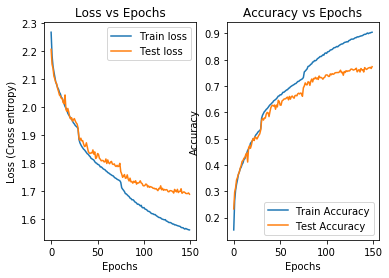

In [13]:
plot_graph(training_losses, test_losses, train_acc, test_acc)

In [11]:
model

Network(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=128, out_features=10, bias=True)
  (global_max_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (softmax): Softmax()
)

In [68]:
# retrieve conv1 layer, convert to numpy array, put on cpu first
weights = model.conv1.weight.data.cpu()

# reshaped = weights.view(64, 11, 11, 3)

# reshaped
# weights = model.conv1.weight.data

In [78]:
def norm_stretch(filter):
    
    filter = filter - torch.min(filter)
    
    return filter / torch.max(filter)
    

In [85]:
# plot filters
def plot_kernels(tensor, num_rows=8, num_cols=8):

    fig = plt.figure(figsize=(num_cols,num_rows))
    
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)  
        
        # need to reshape it to move channels to end
        reshaped = tensor[i].view(11,11,3)
        norm_tensor = norm_stretch(reshaped)
        
#         print(norm_tensor.shape)
        
#         ax1.imshow(tensor[i])
        ax1.imshow(norm_tensor)
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
    
#     plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.savefig('filters.jpg')
    plt.show()
    plt.clf()
    

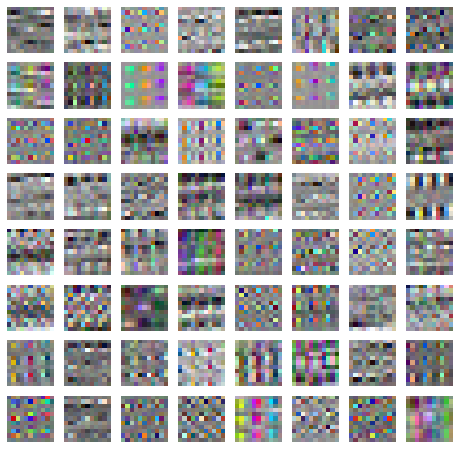

<Figure size 432x288 with 0 Axes>

In [86]:
plot_kernels(weights)